# Visualization

> Necessary scripts to visualize orbits

In [1]:
#| default_exp visualize

In [ ]:
#| export
#| hide
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import seaborn as sns
import os
from scipy import stats
from typing import Optional, List, Dict, Union, Any

In [3]:
#| hide
from fastcore.test import test_eq

## Points

In [4]:
#| export
def plot_3d_points(data, labels=None, plot_velocity=True, arrow_width=0.005, show_legend=True, figsize=(10, 8)):
    """
    Plots each point in space with a 3D arrow based on the first 3 coordinates (position)
    and optionally the next 3 coordinates (velocity).

    Parameters:
    data (numpy.ndarray): Array of shape (samples, 3) for positions or (samples, 6) for positions and velocities.
                          - data[:, 0:3] represents the 3D positions (x, y, z)
                          - data[:, 3:6] represents the velocity components (vx, vy, vz) if provided
    labels (list of str): Optional list of labels for color coding the points.
    plot_velocity (bool): If True and velocities are provided, plot arrows representing velocity vectors.
    arrow_width (float): Width of the arrows.
    show_legend (bool): If True, show the legend for color coding.
    figsize (tuple): Size of the figure in inches (width, height). Default is (10, 8).
    """
    # Check if velocities are provided by looking at the shape of the input data
    if data.shape[1] == 6:
        # Both positions and velocities are provided
        positions = data[:, 0:3]
        velocities = data[:, 3:6]
    elif data.shape[1] == 3:
        # Only positions are provided
        positions = data[:, 0:3]
        velocities = None
        plot_velocity = False  # Disable velocity plotting since it's not available
    else:
        raise ValueError("Data must have shape (samples, 3) for positions or (samples, 6) for positions and velocities.")

    # Create a 3D plot with adjustable size
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Color mapping if labels are provided
    if labels is not None:
        unique_labels = list(set(labels))
        colors = plt.colormaps['viridis'](np.linspace(0, 1, len(unique_labels)))
        label_color_mapping = {label: colors[i] for i, label in enumerate(unique_labels)}

    # Plot each point with an optional arrow
    for i, pos in enumerate(positions):
        # Determine the color based on label
        color = label_color_mapping[labels[i]] if labels is not None else 'blue'
        
        # Plot the point in space
        ax.scatter(pos[0], pos[1], pos[2], color=color,
                   label=labels[i] if labels is not None and labels[i] not in ax.get_legend_handles_labels()[1] else "")

        # Add an arrow representing the velocity vector if plot_velocity is True and velocities exist
        if plot_velocity and velocities is not None:
            vel = velocities[i]
            ax.quiver(
                pos[0], pos[1], pos[2],  # Starting point of the arrow
                vel[0], vel[1], vel[2],  # Direction and length of the arrow
                color='red', length=1, normalize=True,
                linewidths=arrow_width
            )

    # Set labels
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Set limits to fully see the arrows within the plot
    x_limits = [np.min(positions[:, 0]) - 1, np.max(positions[:, 0]) + 1]
    y_limits = [np.min(positions[:, 1]) - 1, np.max(positions[:, 1]) + 1]
    z_limits = [np.min(positions[:, 2]) - 1, np.max(positions[:, 2]) + 1]
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_zlim(z_limits)

    # Show legend if required
    if show_legend and labels is not None:
        ax.legend()

    # Show plot
    plt.show()

## Orbits

### Static

In [ ]:
#| export
def visualize_static_orbits(data: np.ndarray,  # The orbit data with shape (num_orbits, 6, num_time_points).
                            time_instants: Optional[List[int]] = None,  # Time points to highlight; defaults to None.
                            orbit_indices: Optional[List[int]] = None,  # Indices of orbits to visualize; defaults to all.
                            point_dict: Optional[Dict[str, tuple]] = None,  # Dictionary of extra points to plot.
                            show_legend: bool = True,  # Flag to indicate whether to show a legend.
                            save_path: Optional[str] = None,  # Path to save the figure; defaults to None.
                            plot_reference_box: bool = True,  # Flag to indicate whether to plot the reference box.
                            title: Optional[str] = None,  # Custom title for the plot.
                            orbit_names: Optional[List[str]] = None,  # Custom names for orbits; defaults to "Orbit {index}".
                            equal_aspect: bool = False  # Flag to enforce equal scaling for all axes.
                           ) -> None:
    """
    Visualizes orbits in 3D space and highlights specified time instants for each selected orbit.

    Args:
        data (np.ndarray): The orbit data with shape (num_orbits, 6, num_time_points).
        time_instants (Optional[List[int]]): Time points to highlight; defaults to None.
        orbit_indices (Optional[List[int]]): Indices of orbits to visualize; defaults to all.
        point_dict (Optional[Dict[str, tuple]]): Dictionary of extra points to plot.
        show_legend (bool): Flag to indicate whether to show a legend.
        save_path (Optional[str]): Path to save the figure; defaults to None.
        plot_reference_box (bool): Flag to indicate whether to plot the reference box.
        title (Optional[str]): Custom title for the plot.
        orbit_names (Optional[List[str]]): Custom names for orbits; defaults to "Orbit {index}".
        equal_aspect (bool): Flag to enforce equal scaling for all axes.

    Returns:
        None
    """
    
    # Use Matplotlib's Computer Modern font
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['DejaVu Serif'],
        'font.size': 10,
        'text.usetex': False
    })

    if time_instants is None:
        time_instants = []  # Initialize to empty list if None.

    # Validate time instants are within the range of available time points.
    max_time_instants = data.shape[2]
    for time_instant in time_instants:
        if time_instant < 0 or time_instant >= max_time_instants:
            raise ValueError(f"Time instant {time_instant} is out of range.")

    # Validate orbit indices are within the range of available orbits.
    num_orbits = data.shape[0]
    if orbit_indices is None:
        orbit_indices = range(num_orbits)  # Use all orbits by default.
    else:
        for index in orbit_indices:
            if index < 0 or index >= num_orbits:
                raise ValueError(f"Orbit index {index} is out of range.")

    # Setup a 3D plot.
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each selected orbit with custom names if provided.
    for idx, index in enumerate(orbit_indices):
        X = data[index, 0, :]  # X coordinates
        Y = data[index, 1, :]  # Y coordinates
        Z = data[index, 2, :]  # Z coordinates
        
        # Use custom orbit name if provided; otherwise default to "Orbit {index}".
        orbit_label = orbit_names[idx] if orbit_names and idx < len(orbit_names) else f'Orbit {index}'
        
        ax.plot(X, Y, Z, label=orbit_label, alpha=0.5)  # Plot each orbit with a label.

    # Highlight specified time instants and add them to the legend.
    colors = plt.cm.jet(np.linspace(0, 1, len(time_instants)))
    legend_added = set()  # Track which labels have been added to the legend
    if time_instants:
        for time_instant, color in zip(time_instants, colors):
            for index in orbit_indices:
                posx, posy, posz = data[index, 0:3, time_instant]
                label = f'Time {time_instant}'
                if label not in legend_added:
                    ax.scatter(posx, posy, posz, color=color, s=100, zorder=5, label=label)
                    legend_added.add(label)
                else:
                    ax.scatter(posx, posy, posz, color=color, s=100, zorder=5)

    # Plot additional points if provided.
    if point_dict:
        for point_name, coords in point_dict.items():
            ax.scatter(*coords, label=point_name, s=100)

    # Set labels and title.
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.title(title if title else '3D Orbits Static Visualization')

    # Display the legend if requested.
    if show_legend:
        ax.legend()

    # Handle axis scaling based on `equal_aspect` parameter
    if equal_aspect:
        x_range = np.ptp(data[:, 0])
        y_range = np.ptp(data[:, 1])
        z_range = np.ptp(data[:, 2])
        
        max_range = max(x_range, y_range, z_range)
        
        ax.set_box_aspect([x_range / max_range,
                           y_range / max_range,
                           z_range / max_range]) 

    # Set axis limits and background options
    ax.set_xlim([data[:, 0].min(), data[:, 0].max()])
    ax.set_ylim([data[:, 1].min(), data[:, 1].max()])
    ax.set_zlim([data[:, 2].min(), data[:, 2].max()])

    if plot_reference_box:
        ax.grid(True)
    else:
        ax.grid(False)

    # Save the figure if a save path is provided.
    if save_path:
        plt.savefig(save_path)

    plt.show()

In [6]:
#| export
def visualize_orbits_minimal(data: np.ndarray,  # The orbit data with shape (num_orbits, 6, num_time_points).
                             orbit_indices: Optional[List[int]] = None,  # Indices of orbits to visualize; defaults to all.
                             time_instants: Optional[List[int]] = None,  # Time points to highlight; defaults to None.
                             save_path: Optional[str] = None  # Path to save the figure; defaults to None.
                            ) -> None:
    """
    Visualizes orbits in 3D space with a completely blank background (no axes, no labels, no grid).
    """

    # Validate time instants are within the range of available time points.
    max_time_instants = data.shape[2]
    if time_instants is None:
        time_instants = []
    
    for time_instant in time_instants:
        if time_instant < 0 or time_instant >= max_time_instants:
            raise ValueError(f"Time instant {time_instant} is out of range.")
    
    # Validate orbit indices are within the range of available orbits.
    num_orbits = data.shape[0]
    if orbit_indices is None:
        orbit_indices = range(num_orbits)  # Use all orbits by default.
    else:
        for index in orbit_indices:
            if index < 0 or index >= num_orbits:
                raise ValueError(f"Orbit index {index} is out of range.")

    # Setup a 3D plot with a transparent figure and no grid/axes.
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Turn off everything that makes the plot non-blank.
    ax.set_axis_off()  # Removes the axis lines, ticks, labels, etc.
    ax.grid(False)  # Ensure there's no grid.

    # Plot each selected orbit.
    for index in orbit_indices:
        X = data[index, 0, :]  # X coordinates
        Y = data[index, 1, :]  # Y coordinates
        Z = data[index, 2, :]  # Z coordinates
        ax.plot(X, Y, Z, alpha=1.0)  # Full alpha for solid lines.

    # Highlight specified time instants if any are provided.
    if time_instants:
        colors = plt.cm.jet(np.linspace(0, 1, len(time_instants)))  # Generate a color map for the instants.
        for time_instant, color in zip(time_instants, colors):
            for index in orbit_indices:
                posx, posy, posz = data[index, 0:3, time_instant]
                ax.scatter(posx, posy, posz, color=color, s=100, zorder=5)  # Highlight time instant.

    # Save the figure if a save path is provided.
    if save_path:
        plt.savefig(save_path, transparent=True, bbox_inches='tight', pad_inches=0)  # Transparent background.
    
    # Show the plot.
    plt.show()

In [ ]:
#| export
def visualize_orbits_comparison(data1: np.ndarray, 
                             data2: np.ndarray,
                             title1: Optional[str] = "Set 1",
                             title2: Optional[str] = "Set 2",
                             equal_aspect: bool = False,
                             title_size: int = 18,
                             shared_scale: bool = False) -> None:
    """
    Visualizes two sets of orbits side by side in 3D space.

    Args:
        data1 (np.ndarray): First set of orbit data with shape (num_orbits, 6, num_time_points)
        data2 (np.ndarray): Second set of orbit data with shape (num_orbits, 6, num_time_points)
        title1 (str): Title for the first plot
        title2 (str): Title for the second plot
        equal_aspect (bool): Flag to enforce equal scaling for all axes
        title_size (int): Font size for the plot titles
        shared_scale (bool): If True, both plots will share the same scale and limits

    Returns:
        None
    """
    # Use Matplotlib's Computer Modern font
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['DejaVu Serif'],
        'font.size': 10,
        'text.usetex': False
    })

    # Create figure with two subplots side by side
    fig = plt.figure(figsize=(20, 8))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    # Plot first set of orbits
    for i in range(data1.shape[0]):
        X = data1[i, 0, :]  # X coordinates
        Y = data1[i, 1, :]  # Y coordinates
        Z = data1[i, 2, :]  # Z coordinates
        ax1.plot(X, Y, Z, alpha=0.5)

    # Plot second set of orbits
    for i in range(data2.shape[0]):
        X = data2[i, 0, :]  # X coordinates
        Y = data2[i, 1, :]  # Y coordinates
        Z = data2[i, 2, :]  # Z coordinates
        ax2.plot(X, Y, Z, alpha=0.5)

    # Set labels and titles
    for ax in [ax1, ax2]:
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.grid(True)

    ax1.set_title(title1, fontsize=title_size)  # Set title size
    ax2.set_title(title2, fontsize=title_size)  # Set title size

    # Handle axis scaling based on equal_aspect parameter
    if equal_aspect:
        for ax, data in [(ax1, data1), (ax2, data2)]:
            x_range = np.ptp(data[:, 0])
            y_range = np.ptp(data[:, 1])
            z_range = np.ptp(data[:, 2])
            
            max_range = max(x_range, y_range, z_range)
            
            ax.set_box_aspect([x_range / max_range,
                               y_range / max_range,
                               z_range / max_range])

    # Calculate shared limits if requested
    if shared_scale:
        x_min = min(data1[:, 0].min(), data2[:, 0].min())
        x_max = max(data1[:, 0].max(), data2[:, 0].max())
        y_min = min(data1[:, 1].min(), data2[:, 1].min())
        y_max = max(data1[:, 1].max(), data2[:, 1].max())
        z_min = min(data1[:, 2].min(), data2[:, 2].min())
        z_max = max(data1[:, 2].max(), data2[:, 2].max())
        
        # Set same limits for both plots
        for ax in [ax1, ax2]:
            ax.set_xlim([x_min, x_max])
            ax.set_ylim([y_min, y_max])
            ax.set_zlim([z_min, z_max])
            
            # Set same viewing angle for both plots
            ax.view_init(elev=20, azim=45)
    else:
        # Original separate limits
        ax1.set_xlim([data1[:, 0].min(), data1[:, 0].max()])
        ax1.set_ylim([data1[:, 1].min(), data1[:, 1].max()])
        ax1.set_zlim([data1[:, 2].min(), data1[:, 2].max()])

        ax2.set_xlim([data2[:, 0].min(), data2[:, 0].max()])
        ax2.set_ylim([data2[:, 1].min(), data2[:, 1].max()])
        ax2.set_zlim([data2[:, 2].min(), data2[:, 2].max()])

    plt.tight_layout()
    plt.show()

In [7]:
#| test
from orbit_generation.data import get_example_orbit_data
from orbit_generation.constants import EM_POINTS

In [8]:
#| test
orbit_data= get_example_orbit_data()
orbit_data.shape

(200, 6, 300)

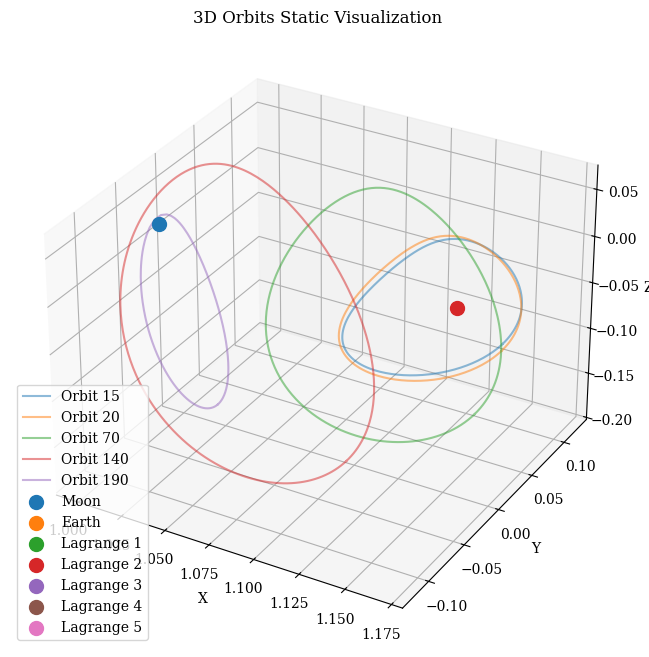

In [9]:
visualize_static_orbits(data= orbit_data, orbit_indices=[15,20,70,140,190], point_dict=EM_POINTS)

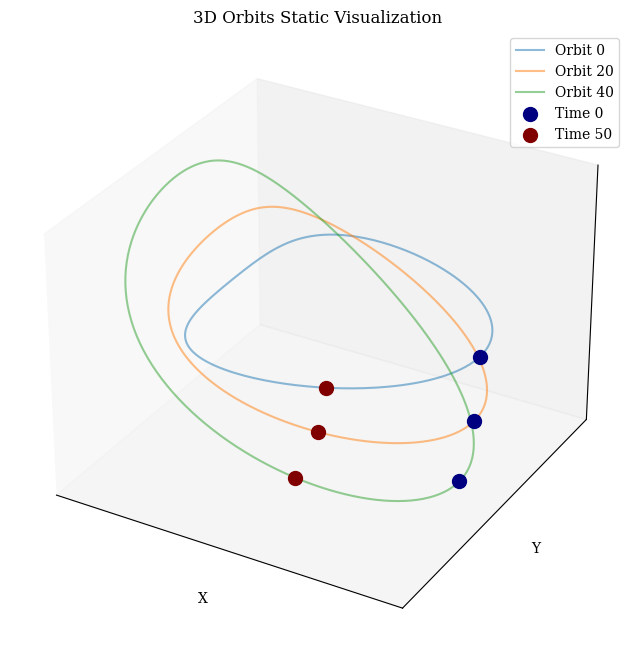

In [10]:
visualize_static_orbits(data= orbit_data,time_instants=[0,50], orbit_indices=[0,20,40], plot_reference_box=False)

In [11]:
#| hide
#| test "invalid time_instants raises ValueError"
time_instants = [-1, 11]  # Out of bounds
try:
    visualize_static_orbits(orbit_data, time_instants)
    test_eq(True, False)  # Test fails if no error is raised
except ValueError:
    test_eq(True, True)  # Test passes if ValueError is raised
except Exception as e:
    test_eq(True, False)  # Unexpected error raised

# Test for "invalid orbit_indices raises ValueError"
time_instants = [0, 9]  # Valid
orbit_indices = [201]  # Out of bounds
try:
    visualize_static_orbits(orbit_data, time_instants, orbit_indices)
    test_eq(True, False)  # Test fails if no error is raised
except ValueError as e:
    test_eq("Orbit index 201 is out of range." in str(e), True)  # Check for correct message
except Exception as e:
    test_eq(True, False)  # Unexpected error raised

### Dynamic

In [12]:
#| export
def export_dynamic_orbits_html(data: np.ndarray,  # Orbit data as a 3D numpy array (num_orbits, 6, num_time_points).
                               time_instants: Optional[List[int]] = None,  # Time instants to highlight.
                               orbit_indices: Optional[List[int]] = None,  # Indices of orbits to visualize.
                               point_dict: Optional[Dict[str, tuple]] = None,  # Named points as a dict with 3D coordinates.
                               filename: str = 'orbits.html'  # Path and name of the file to save the HTML plot.
                               ) -> None:
    """
    Generates an interactive 3D visualization of orbits and saves it as an HTML file, including the ability to
    highlight specific time instants and show named points.
    """
    if time_instants is None:
        time_instants = []  # Ensure time_instants is initialized if None.

    num_orbits = data.shape[0]  # Total number of orbits in the dataset.
    if orbit_indices is None:
        orbit_indices = list(range(num_orbits))  # Default to visualizing all orbits if none specified.

    fig = go.Figure()  # Initialize the plotly figure.

    # Validate and plot each orbit.
    for index in orbit_indices:
        if index < 0 or index >= num_orbits:
            raise ValueError(f"Orbit index {index} is out of range.")
        
        # Extract coordinates for the plot.
        X = data[index, 0, :]  # X coordinates.
        Y = data[index, 1, :]  # Y coordinates.
        Z = data[index, 2, :]  # Z coordinates.
        fig.add_trace(go.Scatter3d(x=X, y=Y, z=Z, mode='lines',
                                   name=f'Orbit {index}',
                                   legendgroup=f'orbit{index}',
                                   showlegend=True))

        # Highlight specific time instants.
        if time_instants:
            for timestamp in time_instants:
                if timestamp < 0 or timestamp >= data.shape[2]:
                    raise ValueError(f"The provided timestamp {timestamp} is out of range.")
                highlight_x = [data[index, 0, timestamp]]
                highlight_y = [data[index, 1, timestamp]]
                highlight_z = [data[index, 2, timestamp]]
                fig.add_trace(go.Scatter3d(x=highlight_x, y=highlight_y, z=highlight_z, mode='markers',
                                           marker=dict(size=5, color='red'),
                                           name=f'Highlight {index} @ {timestamp}',
                                           legendgroup=f'orbit{index}',
                                           showlegend=False))

    # Add additional points from point_dict to the plot.
    if point_dict:
        for point_name, coords in point_dict.items():
            fig.add_trace(go.Scatter3d(x=[coords[0]], y=[coords[1]], z=[coords[2]], mode='markers',
                                       marker=dict(size=5),
                                       name=point_name))

    # Configure the layout of the plot.
    fig.update_layout(title='3D Orbits Visualization',
                      scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                      width=800, height=600,
                      legend_title="Orbits Legend",
                      clickmode='event+select')

    # Write the plot to an HTML file.
    fig.write_html(filename)
    print(f"Visualization saved to {filename}")

In [13]:
export_dynamic_orbits_html(data=orbit_data, filename='../data/example_data/example_orbits.html')

Visualization saved to ../data/example_data/example_orbits.html


[View Orbit Visualization](../data/example_orbits.html)


In [14]:
#| hide
data = np.zeros((3, 6, 50))  # Dummy data with 3 orbits, 6 parameters, 50 time points
time_instants = [-1, 51]  # Invalid time_instants
orbit_indices = [0, 1]  # Valid orbit indices
filename = 'test_orbits.html'  # Filename for saving the HTML

# Using try-except to catch ValueError and test with test_eq
try:
    export_dynamic_orbits_html(data, time_instants, orbit_indices, filename=filename)
    test_eq(True, False)  # Test fails if no error is raised
except ValueError:
    test_eq(True, True)  # Test passes if ValueError is raised
except Exception as e:
    test_eq(True, False)  # Unexpected error raised

# Test for "invalid orbit_indices raises ValueError"
time_instants = [10, 20]  # Valid time_instants
orbit_indices = [3, 4]  # Invalid orbit indices (out of range for given data)

# Using try-except to catch ValueError and test with test_eq
try:
    export_dynamic_orbits_html(data, time_instants, orbit_indices, filename=filename)
    test_eq(True, False)  # Test fails if no error is raised
except ValueError:
    test_eq(True, True)  # Test passes if ValueError is raised
except Exception as e:
    test_eq(True, False)  # Unexpected error raised

## Orbit Features

In [15]:
#| export
def plot_histogram(data, bins=10, title='Histogram', xlabel='Data', ylabel='Frequency'):
    """
    Plots a histogram for the given data.

    Parameters:
    data : list, array, or pandas Series
        The data to be plotted.
    bins : int, optional
        Number of histogram bins to use (default is 10).
    title : str, optional
        Title of the histogram (default is 'Histogram').
    xlabel : str, optional
        Label for the x-axis (default is 'Data').
    ylabel : str, optional
        Label for the y-axis (default is 'Frequency').
    """
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.show()

In [16]:
#| export
def plot_grouped_features(df: pd.DataFrame,               # DataFrame containing the data.
                          columns: List[str],             # List of column names to plot.
                          group_col: str,                 # Column name to group by.
                          plot_type: str,                 # Type of plot: 'violin', 'box', 'facetgrid', or 'histogram'
                          figsize: tuple = (5, 5),        # Size of the plot (width, height) per subplot
                          fontsize: int = 10              # Font size for labels and titles
                         ) -> None:
    """
    Group the DataFrame by a specified column and plot the specified type of plot for each column for each group.
    
    Parameters:
    - df : pd.DataFrame : The DataFrame containing the data.
    - columns : List[str] : List of column names to plot.
    - group_col : str : Column name to group by.
    - plot_type : str : Type of plot ('violin', 'box', 'facetgrid', or 'histogram').
    - figsize : tuple : Size of each subplot (width, height). Default is (5, 5).
    - fontsize : int : Font size for labels and titles. Default is 10.
    """
    if plot_type not in ['violin', 'box', 'facetgrid', 'histogram']:
        raise ValueError("plot_type must be one of 'violin', 'box', 'facetgrid', or 'histogram'")
    
    plt.rcParams.update({'font.size': fontsize})
    
    if plot_type in ['violin', 'box']:
        fig, axs = plt.subplots(1, len(columns), figsize=(figsize[0] * len(columns), figsize[1]))
        
        if len(columns) == 1:
            axs = [axs]
        
        for i, column in enumerate(columns):
            if plot_type == 'violin':
                sns.violinplot(x=group_col, y=column, data=df, ax=axs[i])
                axs[i].set_title(f'Violin plot of {column.capitalize()} by {group_col.capitalize()}', fontsize=fontsize+2)
            elif plot_type == 'box':
                sns.boxplot(x=group_col, y=column, data=df, ax=axs[i])
                axs[i].set_title(f'Box plot of {column.capitalize()} by {group_col.capitalize()}', fontsize=fontsize+2)
            axs[i].set_xlabel(group_col.capitalize(), fontsize=fontsize)
            axs[i].set_ylabel(column.capitalize(), fontsize=fontsize)
            axs[i].tick_params(axis='both', which='major', labelsize=fontsize)
            # Rotate x-axis labels vertically
            axs[i].tick_params(axis='x', rotation=90)
        
        plt.tight_layout()
        plt.show()

    elif plot_type == 'facetgrid':
        for column in columns:
            g = sns.FacetGrid(df, col=group_col, col_wrap=4, height=figsize[1], sharex=False, sharey=False)
            g.map(plt.hist, column, bins=20, edgecolor='black')
            g.set_axis_labels(column.capitalize(), 'Frequency')
            g.set_titles(col_template=f"{column.capitalize()} | {{col_name}} {group_col}")
            for ax in g.axes.flat:
                ax.tick_params(axis='both', which='major', labelsize=fontsize)
                ax.set_xlabel(ax.get_xlabel(), fontsize=fontsize)
                ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize)
                ax.set_title(ax.get_title(), fontsize=fontsize+2)
                # Rotate x-axis labels vertically
                ax.tick_params(axis='x', rotation=90)
            plt.tight_layout()
            plt.show()

    elif plot_type == 'histogram':
        grouped = df.groupby(group_col)

        for group_name, group in grouped:
            num_columns = len(columns)
            fig, axs = plt.subplots(1, num_columns, figsize=(figsize[0] * num_columns, figsize[1]))
            
            if num_columns == 1:
                axs = [axs]
            
            for i, column in enumerate(columns):
                axs[i].hist(group[column], bins=20, edgecolor='black')
                axs[i].set_title(f'{column.capitalize()} for {group_col.capitalize()}: {group_name}', fontsize=fontsize+2)
                axs[i].set_xlabel(column.capitalize(), fontsize=fontsize)
                axs[i].set_ylabel('Frequency', fontsize=fontsize)
                axs[i].tick_params(axis='both', which='major', labelsize=fontsize)
                # Rotate x-axis labels vertically
                axs[i].tick_params(axis='x', rotation=90)
                axs[i].grid(True)
            
            plt.tight_layout()
            plt.show()

In [17]:
#| export
def plot_value_proportions(data: Optional[Union[List[int], np.ndarray]],  # List or array of ID values to filter the DataFrame.
                           classification_df: pd.DataFrame,               # DataFrame containing the data.
                           id_col_classification: Optional[str] = None,   # Column name to be used as ID.
                           grid: Optional[str] = 'horizontal',            # Option to plot in grid (horizontal, vertical, or square) or separate images.
                           show_percentages: Union[bool, List[bool]] = True, # Option to print or not print percentages.
                           show_labels: Union[bool, List[bool]] = True,      # Option to print or not print labels.
                           percentage_font_size: int = 10,                # Font size for percentages.
                           label_distance: float = 1.1,                   # Distance of labels from center.
                           pct_distance: float = 0.85,                    # Distance of percentages from center.
                           explode_factor: float = 0.1                    # Factor to separate slices.
                          ) -> None:
    """
    Count occurrences of each unique value in data, map those counts to the DataFrame,
    and plot the proportions in pie charts for each column except the ID column.
    """
    if data is not None:
        if isinstance(data, np.ndarray):
            data = data.tolist()
        data_series = pd.Series(data)
        data_counts = data_series.value_counts()
        # Map counts to the DataFrame
        if id_col_classification:
            labels = classification_df.set_index(id_col_classification).loc[data_series].index
        else:
            labels = classification_df.loc[data_series.index].index
    else:
        labels = classification_df.index

    label_counts = pd.Series(labels).value_counts()

    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))
            return f'{pct:.1f}%' if show_percentages else None
        return my_autopct

    columns_to_plot = [col for col in classification_df.columns if col != id_col_classification]
    num_cols = len(columns_to_plot)
    alphabet = 'abcdefghijklmnopqrstuvwxyz'

    # Handle list or single boolean for show_percentages and show_labels
    if isinstance(show_percentages, bool):
        show_percentages = [show_percentages] * num_cols
    if isinstance(show_labels, bool):
        show_labels = [show_labels] * num_cols

    def plot_pie(ax, values, title, idx, show_pct, show_lbl):
        explode = [explode_factor] * len(values)
        autopct = make_autopct(values) if show_pct else None
        labels = values.index if show_lbl else None
        ax.pie(values, labels=labels, autopct=autopct, startangle=140,
               textprops={'fontsize': percentage_font_size}, labeldistance=label_distance if show_lbl else None,
               pctdistance=pct_distance if show_pct else None, explode=explode)
        ax.set_title(f'{alphabet[idx]}) {title}')
        ax.axis('equal')
        total_classes = len(values)
        ax.text(0, 0, str(total_classes), ha='center', va='center', fontsize=12, weight='bold')

    if grid == 'horizontal':
        fig, axes = plt.subplots(1, num_cols, figsize=(num_cols * 6, 6))
        axes = np.atleast_1d(axes)  # Ensure axes is always an array, even with a single subplot
        for i, column in enumerate(columns_to_plot):
            values = classification_df[column].reindex(labels).value_counts()
            plot_pie(axes[i], values, f'Proportion of orbits by {column}', i, show_percentages[i], show_labels[i])
        plt.tight_layout()
        plt.show()
    elif grid == 'vertical':
        fig, axes = plt.subplots(num_cols, 1, figsize=(6, num_cols * 6))
        axes = np.atleast_1d(axes)  # Ensure axes is always an array, even with a single subplot
        for i, column in enumerate(columns_to_plot):
            values = classification_df[column].reindex(labels).value_counts()
            plot_pie(axes[i], values, f'Proportion of orbits by {column}', i, show_percentages[i], show_labels[i])
        plt.tight_layout()
        plt.show()
    elif grid == 'square':
        grid_size = int(np.ceil(np.sqrt(num_cols)))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 6, grid_size * 6))
        axes = axes.flatten()  # Flatten the 2D array of axes to make indexing easier
        for i, column in enumerate(columns_to_plot):
            values = classification_df[column].reindex(labels).value_counts()
            plot_pie(axes[i], values, f'Proportion of orbits by {column}', i, show_percentages[i], show_labels[i])
        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
        plt.tight_layout()
        plt.show()
    else:
        for i, column in enumerate(columns_to_plot):
            plt.figure(figsize=(6, 6))
            values = classification_df[column].reindex(labels).value_counts()
            ax = plt.gca()
            plot_pie(ax, values, f'Proportion of orbits by {column}', i, show_percentages[i], show_labels[i])
            plt.show()

In [18]:
#| export
def plot_mean_distance_by_group_column(df, group_column, value_column):
    # Calculate mean and standard deviation for each group
    stats_df = df.groupby(group_column)[value_column].agg(['mean', 'std']).reset_index()

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot mean distances with error bars
    plt.errorbar(stats_df[group_column], stats_df['mean'], 
                 yerr=stats_df['std'], fmt='o', capsize=5, capthick=2, 
                 ecolor='red', markeredgecolor='black', markerfacecolor='blue')

    # Customize the plot
    plt.title(f'Mean {value_column} by {group_column}', fontsize=16)
    plt.xlabel(f'{group_column}', fontsize=14)
    plt.ylabel(f'Mean {value_column}', fontsize=14)
    plt.xticks(stats_df[group_column])
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add text labels for mean and std dev
    for i, row in stats_df.iterrows():
        plt.text(row[group_column], row['mean'], 
                 f"Mean: {row['mean']:.2f}\nStd: {row['std']:.2f}", 
                 horizontalalignment='left', verticalalignment='bottom')

    plt.tight_layout()
    plt.show()

## Dataframe

### Correlation Matrix

In [19]:
#| export
def plot_corr_matrix(dataframe: pd.DataFrame, figsize=(14, 10), cmap='coolwarm', save_path: Optional[str] = None):
    """
    Plots a correlation matrix heatmap with annotations.
    
    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the data to be analyzed.
    figsize (tuple): The size of the figure (width, height).
    cmap (str): The color map to be used for the heatmap.
    save_path (Optional[str]): The path to save the plot image. If None, the plot is not saved.
    
    Returns:
    None: Displays the correlation matrix heatmap.
    """
    # Calculate the correlation matrix
    corr_matrix = dataframe.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=figsize)

    # Draw the heatmap with the correlation numbers
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap, cbar=True, linewidths=.5, square=True)

    # Set the title
    plt.title('Correlation Matrix of Metrics')

    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    # Show the plot
    plt.show()

### Features Summary

In [20]:
#| export
def summarize_and_test(
    df: pd.DataFrame, 
    group_col: str, 
    features: List[str] = None, 
    visualize: bool = True, 
    figsize: tuple = (10, 40), 
    plot_significant_only: bool = True,
    plot_continuous: bool = False,
    show_values: bool = True
) -> Dict[str, Any]:
    
    def group_and_summarize(df: pd.DataFrame, group_col: str, features: List[str]) -> Dict[str, Dict[str, Any]]:
        summary_stats = {}
        groups = df[group_col].unique()
        for group in groups:
            group_data = df[df[group_col] == group]
            mean_values = group_data[features].mean()
            std_dev = group_data[features].std()
            summary_stats[group] = {'mean': mean_values, 'std_dev': std_dev}
        return summary_stats

    def perform_anova(df: pd.DataFrame, group_col: str, features: List[str]) -> Dict[str, Dict[str, Any]]:
        anova_results = {}
        for feature in features:
            groups = [group[feature].dropna() for name, group in df.groupby(group_col)]
            f_stat, p_value = stats.f_oneway(*groups)
            anova_results[feature] = {'f_stat': f_stat, 'p_value': p_value}
        return anova_results

    def visualize_summary(summary_stats: dict, anova_results: dict, figsize: tuple, plot_significant_only: bool):
        groups = list(summary_stats.keys())
        features = list(next(iter(summary_stats.values()))['mean'].index)

        # Ensure groups are sorted for proper plotting order
        groups.sort()

        # Filter significant features if required
        if plot_significant_only:
            features = [feature for feature in features if anova_results[feature]['p_value'] < 0.05]

        # Check if there are any features to plot
        if not features:
            print("No significant features to plot.")
            return

        # Generate a color palette
        color_palette = sns.color_palette("husl", n_colors=len(features))

        fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=figsize)
        if len(features) == 1:
            axes = [axes]
        fig.tight_layout(pad=5.0)

        for i, feature in enumerate(features):
            means = [summary_stats[group]['mean'][feature] for group in groups]
            std_devs = [summary_stats[group]['std_dev'][feature] for group in groups]

            if plot_continuous:
                # Plot continuous line for means
                axes[i].plot(groups, means, marker='o', color=color_palette[i], label=f'{feature} Mean')
                # Plot shaded area for standard deviations
                lower_bound = [m - s for m, s in zip(means, std_devs)]
                upper_bound = [m + s for m, s in zip(means, std_devs)]
                axes[i].fill_between(groups, lower_bound, upper_bound,
                                     color=color_palette[i], alpha=0.2)
                
                # Add mean values on top of each dot if show_values is True
                if show_values:
                    for x, y in zip(groups, means):
                        axes[i].text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=10)
                
                axes[i].set_title(f'{feature} (p={anova_results[feature]["p_value"]:.3f})')
                axes[i].set_ylabel('Value')
                axes[i].legend()
            else:
                # Plot bar chart with error bars
                bars = axes[i].bar(groups, means, yerr=std_devs, capsize=5, color=color_palette)
                
                p_value = anova_results[feature]['p_value']
                significance = '*' if p_value < 0.05 else 'ns'
                axes[i].set_title(f'{feature} (p={p_value:.3f}, {significance})')
                axes[i].set_ylabel('Value')
                axes[i].set_ylim(0, max(means) + 1.5 * max(std_devs))

                # Add mean values on top of each bar if show_values is True
                if show_values:
                    for bar in bars:
                        height = bar.get_height()
                        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                                     f'{height:.2f}', ha='center', va='bottom')

        plt.xlabel('Groups')
        plt.show()

    # If features are not specified, use all columns except the grouping column
    if features is None:
        features = [col for col in df.columns if col != group_col]

    # Ensure all specified features exist in the DataFrame
    missing_features = [f for f in features if f not in df.columns]
    if missing_features:
        raise KeyError(f"The following features are not in the DataFrame: {missing_features}")

    summary_stats = group_and_summarize(df, group_col, features)
    anova_results = perform_anova(df, group_col, features)
    
    if visualize:
        visualize_summary(summary_stats, anova_results, figsize, plot_significant_only)
    
    return {
        'summary_stats': summary_stats,
        'anova_results': anova_results
    }


## Other

### Images

In [ ]:
#| export
def plot_single_image(image_path, crop_length=0, font_size=17, save_path=None, figsize=(15, 15), title=None):
    """
    Plot a single image with customization options.

    Args:
        image_path (str): Path to the image file.
        crop_length (int): Number of pixels to crop from each side of the image.
        font_size (int): Font size for the title.
        save_path (str): Path to save the plotted image. If None, the image is not saved.
        figsize (tuple): Size of the figure (width, height).
        title (str): Title for the image.

    Returns:
        None
    """
    if not os.path.exists(image_path):
        print(f"Error: The file '{image_path}' does not exist.")
        return

    # Load and crop the image
    img = Image.open(image_path)
    img = img.crop((crop_length, crop_length, img.width - crop_length, img.height - crop_length))

    # Set up the plot
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')  # Hide axes

    # Add title if provided
    if title:
        plt.title(title, fontsize=font_size)

    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    # Display the plot
    plt.show()


In [ ]:
#| export
def create_image_grid_from_routes(image_routes, crop_length=0, font_size=12, save_path=None, grid_size=(3, 2), hspace=-0.37, label_images=None):
    """
    Create a grid of images from a list of image paths.

    Args:
        image_routes (list): List of image file paths.
        crop_length (int): Number of pixels to crop from each side of the image.
        font_size (int): Font size for the experiment label.
        save_path (str): Path to save the generated grid image. If None, the grid is not saved.
        grid_size (tuple): Number of rows and columns in the grid.
        hspace (float): Vertical spacing between grid rows.
        label_images (list or bool): List of labels for images or a boolean to add default labels.

    Returns:
        None
    """
    # Set up the plot with dynamic grid sizing
    fig, axes = plt.subplots(*grid_size, figsize=(5 * grid_size[1], 5 * grid_size[0]))  # Adjusted figsize dynamically
    axes = axes.flatten()

    # Hide all axes initially
    for ax in axes:
        ax.axis('off')

    max_images = grid_size[0] * grid_size[1]  # Maximum number of images in the grid
    processed_images = 0

    for idx, image_path in enumerate(image_routes):
        if processed_images >= max_images:
            break

        if os.path.exists(image_path):
            # Load and crop the image
            img = Image.open(image_path)
            img = img.crop((crop_length, crop_length, img.width - crop_length, img.height - crop_length))
            
            if label_images:
                # Draw label on the image if label_images is a list or True
                draw = ImageDraw.Draw(img)
                try:
                    font = ImageFont.truetype("arial.ttf", font_size)
                except IOError:
                    font = ImageFont.load_default()
                if isinstance(label_images, list) and idx < len(label_images):
                    text = label_images[idx]
                else:
                    text = f"Image {idx + 1}"
                draw.text((10, 10), text, font=font, fill=(255, 255, 255))

            # Show image in the grid
            axes[processed_images].imshow(img)
            if label_images:
                axes[processed_images].set_title(text)
            processed_images += 1
        else:
            # If the image does not exist, display an error message in the grid cell
            axes[processed_images].text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
            processed_images += 1

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(hspace=hspace)  # Reduce vertical spacing

    # Save the grid if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    # Display the grid
    plt.show()

In [22]:
#| hide
import nbdev; nbdev.nbdev_export()